## Курсовая работа по теме: Библиотеки Python для Data Science: Numpy, Matplotlib, Scikit-learn

## Автор: Шестопалов Виктор

---

# Исследование данных

Загрузим трэйнинг и тест сеты для анализа их содержимого на приедмет корректности данных

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score as r2

import matplotlib.pyplot as plt

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
fits = []
tranformers = []
global_vars = dict()

In [4]:
train_ds = pd.read_csv('train.csv')
test_x_ds = pd.read_csv('test.csv')
test_y_ds = pd.read_csv('sample_submission.csv')
test_y_ds.head()
features_to_predict = list(set(train_ds.columns) - {'Id', 'DistrictId'})
features_to_predict

['Floor',
 'LifeSquare',
 'Ecology_3',
 'Social_3',
 'Shops_1',
 'Rooms',
 'HouseFloor',
 'Social_1',
 'Shops_2',
 'Helthcare_2',
 'Ecology_2',
 'KitchenSquare',
 'Square',
 'HouseYear',
 'Social_2',
 'Ecology_1',
 'Healthcare_1',
 'Price']

In [5]:
# убедимся что данные были загружены корректно
train_ds.head(5)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.871089
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B,177734.553407
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,B,B,33,5261,0,240.0,3,1,B,282078.720850
3,2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,168106.007630
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,B,B,33,8667,2,NaN,0,6,B,343995.102962


---

# Оценка данных

Оценим данные, что бы понять как заполонить пустые\пропущенные значение и как скорректировать значения которые сильно выбиваются среди аналогичных в группах. Или возможно для тренировочного сета можно будет удалить строки с сильноискаженными данными.

In [6]:
train_ds.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.00000,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,4859.01902,43.587592,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.00000,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,4169.50000,20.000000,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,8394.50000,36.000000,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,12592.50000,75.000000,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,16798.00000,209.000000,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


In [7]:
train_ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
Id               10000 non-null int64
DistrictId       10000 non-null int64
Rooms            10000 non-null float64
Square           10000 non-null float64
LifeSquare       7887 non-null float64
KitchenSquare    10000 non-null float64
Floor            10000 non-null int64
HouseFloor       10000 non-null float64
HouseYear        10000 non-null int64
Ecology_1        10000 non-null float64
Ecology_2        10000 non-null object
Ecology_3        10000 non-null object
Social_1         10000 non-null int64
Social_2         10000 non-null int64
Social_3         10000 non-null int64
Healthcare_1     5202 non-null float64
Helthcare_2      10000 non-null int64
Shops_1          10000 non-null int64
Shops_2          10000 non-null object
Price            10000 non-null float64
dtypes: float64(8), int64(9), object(3)
memory usage: 1.5+ MB


---

# Корректировка данных

Пройдемся по каждой колонке отдельно, но начнем с группы по параметрам квартиры: 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare' колонки

Из всех колонок к себе больше всех внимания требует колонка "LifeSquare", так как у нее много пропущенных данных (=nan)

Но для того, что бы исправить пустоты в этой колонке, мы должны проверить на корректность данные соседних, логически связных, колонок, 
так как на основе этих данных мы можем сгенерировать отсуствующие данные в этой колонке.

Данный параметр больше всех остальных независим от остальных параметров, по этому проверим граничные значения

In [8]:
#train_ds['KitchenSquare'].value_counts().sort_index()

все площади кухонь меньше 5-ти квадратов, предположительно, можно считать частью комнаты (стюдия), и можно их прировнять к нулю.

введем новый бинарный признак как ошибку данных площади кухни, а затем все кухни площадью менее 20ти квадратов как равные 21

In [9]:
def Kitchen_Transform(df):
    df['KitchenSquare_small'] = 0
    df.loc[df['KitchenSquare']>20, 'KitchenSquare_small'] = 1
    #df.loc[df['KitchenSquare']<5, "KitchenSquare"] = 0
    df['KitchenSquare_big'] = 0
    df.loc[df['KitchenSquare']>20, 'KitchenSquare_big'] = 1
    #df.loc[df['KitchenSquare']>20, 'KitchenSquare'] = 21
    df['KitchenSquare'].value_counts().sort_index()

tranformers.append(Kitchen_Transform)
features_to_predict.append('KitchenSquare_small')
features_to_predict.append('KitchenSquare_big')
Kitchen_Transform(train_ds) 

не сравнивая эту колонку с другими, она уже имеет вид приемливый к реальным данным

In [10]:
#train_ds['Square'].map(int).value_counts().sort_index()

In [11]:
train_ds['Square'].describe()

count    10000.000000
mean        56.315775
std         21.058732
min          1.136859
25%         41.774881
50%         52.513310
75%         65.900625
max        641.065193
Name: Square, dtype: float64

In [12]:
def Square_Transform(df):
#train_ds.loc[train_ds['Square']<30, "KitchenSquare"] = 0
    df['Square_small'] = 0
    df.loc[df['Square']<30, 'Square_small'] = 1
    #df.loc[df['Square']<30, 'Square'] = 30

tranformers.append(Square_Transform)
Square_Transform(train_ds)   
features_to_predict.append('Square_small')
#train_ds['Square'].map(int).value_counts().sort_index()

рассмотрим нашу группу параметров квартиры еще раз после коррекции

In [13]:
train_ds[[ 'Rooms', 'Square', 'Square_small', 'LifeSquare', 'KitchenSquare', 'KitchenSquare_big']].describe()

,Rooms,Square,Square_small,LifeSquare,KitchenSquare,KitchenSquare_big
count,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000
mean,1.890500,56.315775,0.010500,37.199645,6.273300,0.004800
std,0.839512,21.058732,0.101935,86.241209,28.560917,0.069119
min,0.000000,1.136859,0.000000,0.370619,0.000000,0.000000
25%,1.000000,41.774881,0.000000,22.769832,1.000000,0.000000
50%,2.000000,52.513310,0.000000,32.781260,6.000000,0.000000
75%,2.000000,65.900625,0.000000,45.128803,9.000000,0.000000
max,19.000000,641.065193,1.000000,7480.592129,2014.000000,1.000000


Остаются проблемными показатели максимальных значений количества комнат и жилой площади,
а так же отсуствия данных по жилой площади, но этот пункс рассмотрим ниже

In [14]:
train_ds['Rooms'].map(int).value_counts().sort_index()

0        8
1     3705
2     3880
3     2235
4      150
5       18
6        1
10       2
19       1
Name: Rooms, dtype: int64

[0, 10, 19]

In [15]:
train_ds[train_ds['Rooms'].isna()]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,KitchenSquare_small,KitchenSquare_big,Square_small


У жилой комнаты много пробелов. Для их заполнения рассчитаем недостающую компаненту - медиану не жилой площади и не кухни, а корридора, туалета и д.т. 

In [16]:
def Rooms_Fits(df):
    # отсуствие комнат rooms=0
    train_temp = df[df['Rooms']!=0]
    # пустые значения жилой площади LifeSquare.isna()
    train_temp = train_temp[~train_temp['LifeSquare'].isna()]
    # значения общей площади меньше чем суммарное ее компонент
    train_temp = train_temp[train_temp['Square']>=(train_temp['LifeSquare'] + train_temp['KitchenSquare'])]
    # площади больше 90, возможно это объедененные квартир
    train_temp = train_temp[train_temp['Square']<90]

    train_temp['OtherSquare'] = train_temp['Square'] - train_temp['LifeSquare'] - train_temp['KitchenSquare']
    global_vars['MeanOtherSquare'] = train_temp['OtherSquare'].mean()

fits.append(Rooms_Fits)
Rooms_Fits(train_ds)
print(global_vars['MeanOtherSquare'])

13.568076870895842


In [17]:
def Life_Transform(df):
    df['LifeSquare_nan'] = 0
    df.loc[df['LifeSquare'].isna(), 'LifeSquare_nan'] = 1
    #df.loc[df['LifeSquare'].isna(), 'LifeSquare'] = df['Square'] - df['KitchenSquare'] - global_vars['MeanOtherSquare']
    df.loc[df['LifeSquare'].isna(), 'LifeSquare'] = 0
   
tranformers.append(Life_Transform)
Life_Transform(train_ds)
features_to_predict.append('LifeSquare_nan')
train_ds.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price,KitchenSquare_small,KitchenSquare_big,Square_small,LifeSquare_nan
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,...,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.890500,56.315775,29.339360,6.273300,8.526700,12.609400,3.990166e+03,0.118858,...,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399,0.004800,0.004800,0.010500,0.211300
std,4859.01902,43.587592,0.839512,21.058732,78.079922,28.560917,5.241148,6.775974,2.005003e+05,0.119025,...,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865,0.069119,0.069119,0.101935,0.408251
min,0.00000,0.000000,0.000000,1.136859,0.000000,0.000000,1.000000,0.000000,1.910000e+03,0.000000,...,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028,0.000000,0.000000,0.000000,0.000000
25%,4169.50000,20.000000,1.000000,41.774881,17.627207,1.000000,4.000000,9.000000,1.974000e+03,0.017647,...,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942,0.000000,0.000000,0.000000,0.000000
50%,8394.50000,36.000000,2.000000,52.513310,28.926861,6.000000,7.000000,13.000000,1.977000e+03,0.075424,...,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879,0.000000,0.000000,0.000000,0.000000
75%,12592.50000,75.000000,2.000000,65.900625,41.427234,9.000000,12.000000,17.000000,2.001000e+03,0.195781,...,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171,0.000000,0.000000,0.000000,0.000000
max,16798.00000,209.000000,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,...,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570,1.000000,1.000000,1.000000,1.000000


In [18]:
def Rooms_Transform(df):
    df.loc[(df['Rooms']==0) | (df['Rooms'].isna()), 'Rooms'] = round(df['LifeSquare'] / global_vars['MeanOtherSquare']) + 1
    df.loc[df['Rooms']>5, 'Rooms'] = 5

tranformers.append(Rooms_Transform)
Rooms_Transform(train_ds)
train_ds.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price,KitchenSquare_small,KitchenSquare_big,Square_small,LifeSquare_nan
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,...,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.890100,56.315775,29.339360,6.273300,8.526700,12.609400,3.990166e+03,0.118858,...,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399,0.004800,0.004800,0.010500,0.211300
std,4859.01902,43.587592,0.815407,21.058732,78.079922,28.560917,5.241148,6.775974,2.005003e+05,0.119025,...,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865,0.069119,0.069119,0.101935,0.408251
min,0.00000,0.000000,1.000000,1.136859,0.000000,0.000000,1.000000,0.000000,1.910000e+03,0.000000,...,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028,0.000000,0.000000,0.000000,0.000000
25%,4169.50000,20.000000,1.000000,41.774881,17.627207,1.000000,4.000000,9.000000,1.974000e+03,0.017647,...,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942,0.000000,0.000000,0.000000,0.000000
50%,8394.50000,36.000000,2.000000,52.513310,28.926861,6.000000,7.000000,13.000000,1.977000e+03,0.075424,...,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879,0.000000,0.000000,0.000000,0.000000
75%,12592.50000,75.000000,2.000000,65.900625,41.427234,9.000000,12.000000,17.000000,2.001000e+03,0.195781,...,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171,0.000000,0.000000,0.000000,0.000000
max,16798.00000,209.000000,5.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,...,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570,1.000000,1.000000,1.000000,1.000000


In [19]:
#train_ds[['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear']]

In [20]:
def Floor_Transform(df):
    df.loc[(df['Floor'] > df['HouseFloor']), 'HouseFloor'] = df['Floor']
    df['BigHouseFloor'] = 0
    df.loc[(df['HouseFloor'] > 50), 'BigHouseFloor'] = 1
    #df.loc[(df['HouseFloor'] > 50), 'HouseFloor'] = df['Floor']
    df['fFloor'] = 0
    df.loc[df['Floor'] == 1, 'fFloor'] = 1

tranformers.append(Floor_Transform)
Floor_Transform(train_ds)
train_ds.describe()
features_to_predict.append('BigHouseFloor')
features_to_predict.append('fFloor')
#train_ds[train_ds['HouseYear']==1977]

In [21]:
def Year_Transform(df):
    df['HouseYearBig'] = 0
    df.loc[(df['HouseYear'] > 2020), 'HouseYearBig'] = 1
    df.loc[(df['HouseYear'] > 2021), 'HouseYear'] = 2021
    df.loc[(df['HouseYear'] < 1900), 'HouseYear'] = 1990

tranformers.append(Year_Transform)
Year_Transform(train_ds)
features_to_predict.append('HouseYearBig')
train_ds.head()

#train_ds['HouseYear'].value_counts()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Shops_1,Shops_2,Price,KitchenSquare_small,KitchenSquare_big,Square_small,LifeSquare_nan,BigHouseFloor,fFloor,HouseYearBig
0,11809,27,3.0,115.027311,0.000000,10.0,4,10.0,2014,0.075424,...,0,B,305018.871089,0,0,0,1,0,0,0
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,...,0,B,177734.553407,0,0,0,0,0,0,0
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,...,1,B,282078.720850,0,0,0,0,0,0,0
3,2352,1,1.0,40.409907,0.000000,1.0,10,22.0,1977,0.007122,...,1,B,168106.007630,0,0,0,1,0,0,0
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,...,6,B,343995.102962,0,0,0,0,0,0,0


In [22]:
def Healthcare_Transform(df):
    df['Healthcare_1_nan'] = 0
    df.loc[df['Healthcare_1'].isnull(), 'Healthcare_1_nan'] = 1
    df.loc[df['Healthcare_1'].isnull(), 'Healthcare_1'] = 6
#    df.loc[df['Healthcare_1'].isnull(), 'Healthcare_1'] = 0
    
tranformers.append(Healthcare_Transform)
Healthcare_Transform(train_ds)
train_ds.describe()


,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Shops_1,Price,KitchenSquare_small,KitchenSquare_big,Square_small,LifeSquare_nan,BigHouseFloor,fFloor,HouseYearBig,Healthcare_1_nan
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,...,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.890100,56.315775,29.339360,6.273300,8.526700,13.435700,1984.872600,0.118858,...,4.231300,214138.857399,0.004800,0.004800,0.010500,0.211300,0.000300,0.023500,0.000200,0.479800
std,4859.01902,43.587592,0.815407,21.058732,78.079922,28.560917,5.241148,6.094012,18.416734,0.119025,...,4.806341,92872.293865,0.069119,0.069119,0.101935,0.408251,0.017319,0.151493,0.014141,0.499617
min,0.00000,0.000000,1.000000,1.136859,0.000000,0.000000,1.000000,1.000000,1910.000000,0.000000,...,0.000000,59174.778028,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4169.50000,20.000000,1.000000,41.774881,17.627207,1.000000,4.000000,9.000000,1974.000000,0.017647,...,1.000000,153872.633942,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,8394.50000,36.000000,2.000000,52.513310,28.926861,6.000000,7.000000,14.000000,1977.000000,0.075424,...,3.000000,192269.644879,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,12592.50000,75.000000,2.000000,65.900625,41.427234,9.000000,12.000000,17.000000,2001.000000,0.195781,...,6.000000,249135.462171,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,16798.00000,209.000000,5.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2021.000000,0.521867,...,23.000000,633233.466570,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [23]:
def Binary_Transform(df):
    binary_to_numbers = {'A': 0, 'B': 1}
    df['Ecology_2'] = df['Ecology_2'].map(binary_to_numbers)
    df['Ecology_3'] = df['Ecology_3'].map(binary_to_numbers)
    df['Shops_2'] = df['Shops_2'].map(binary_to_numbers)

tranformers.append(Binary_Transform)
Binary_Transform(train_ds)


In [24]:
global_vars['district_size'] = train_ds['DistrictId'].value_counts().reset_index() \
                               .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})
# DistrictSize - is bad idea
#features_to_predict.append('DistrictSize')  
#global_vars['district_size']

In [25]:
def District_Transform(df):
    df = df.merge(global_vars['district_size'], on='DistrictId', how='left')
    return df
    
tranformers.append(District_Transform)                                                                                          
train_ds = District_Transform(train_ds)
train_ds.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Price,KitchenSquare_small,KitchenSquare_big,Square_small,LifeSquare_nan,BigHouseFloor,fFloor,HouseYearBig,Healthcare_1_nan,DistrictSize
0,11809,27,3.0,115.027311,0.000000,10.0,4,10.0,2014,0.075424,...,305018.871089,0,0,0,1,0,0,0,1,851
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,...,177734.553407,0,0,0,0,0,0,0,0,78
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,...,282078.720850,0,0,0,0,0,0,0,0,652
3,2352,1,1.0,40.409907,0.000000,1.0,10,22.0,1977,0.007122,...,168106.007630,0,0,0,1,0,0,0,1,652
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,...,343995.102962,0,0,0,0,0,0,0,1,89


In [26]:
def Rooms_Transform(df):
    df.loc[(df['Rooms']==0) | (df['Rooms'].isna()), 'Rooms'] = round(df['LifeSquare'] / global_vars['MeanOtherSquare']) + 1
    df.loc[df['Rooms']>5, 'Rooms'] = 5

tranformers.append(Rooms_Transform)
Rooms_Transform(train_ds)
print(train_ds.describe())

                Id    DistrictId         Rooms        Square    LifeSquare  \
count  10000.00000  10000.000000  10000.000000  10000.000000  10000.000000   
mean    8383.40770     50.400800      1.890100     56.315775     29.339360   
std     4859.01902     43.587592      0.815407     21.058732     78.079922   
min        0.00000      0.000000      1.000000      1.136859      0.000000   
25%     4169.50000     20.000000      1.000000     41.774881     17.627207   
50%     8394.50000     36.000000      2.000000     52.513310     28.926861   
75%    12592.50000     75.000000      2.000000     65.900625     41.427234   
max    16798.00000    209.000000      5.000000    641.065193   7480.592129   

       KitchenSquare         Floor    HouseFloor     HouseYear     Ecology_1  \
count   10000.000000  10000.000000  10000.000000  10000.000000  10000.000000   
mean        6.273300      8.526700     13.435700   1984.872600      0.118858   
std        28.560917      5.241148      6.094012     18.4

Уберем исходные колонки которые имеют наименьшее влияние на результаты (информация была получина при прошлой валидации данных)

In [27]:
features_to_predict = set(features_to_predict) - {'Helthcare_2', 'Shops_2', 'Ecology_3', 'Ecology_2'}
train_ds = train_ds[features_to_predict]

<Figure size 1152x576 with 0 Axes>

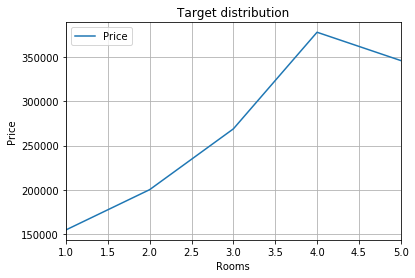

In [28]:
plt.figure(figsize = (16, 8))

#train_ds['Rooms'].hist(bins=100)
df = train_ds[['Rooms', 'Price']].groupby('Rooms', as_index=False).agg({'Price':'median'})

df.plot(y='Price', x='Rooms', grid=True )

#train_ds[['Rooms', 'Price']].plot(x='Price', y='Rooms',figsize=(5,10), grid=True )
plt.ylabel('Price')
plt.xlabel('Rooms')

plt.title('Target distribution')
plt.show()

## Валидация данных

In [29]:
X = train_ds.drop(columns="Price")
y = train_ds["Price"]
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=21)


In [30]:
rf_model = RandomForestRegressor(random_state=21, criterion='mse', n_estimators=100)
rf_model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=21, verbose=0, warm_start=False)

In [31]:
feature_importances = pd.DataFrame(zip(X_train.columns, rf_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
16,Square,3.893178e-01
17,Social_2,1.062084e-01
11,Social_1,1.029563e-01
9,Rooms,7.940150e-02
5,Social_3,5.881965e-02
14,HouseYear,4.424506e-02
18,Ecology_1,4.320835e-02
4,LifeSquare,3.600819e-02
10,HouseFloor,3.148287e-02
15,KitchenSquare,2.993230e-02


In [32]:
y_train_preds = rf_model.predict(X_valid)

#y_valid.shape, y_train_preds.shape
print("Train R2:\t" + str(round(r2(y_valid, y_train_preds), 3)))

Train R2:	0.734


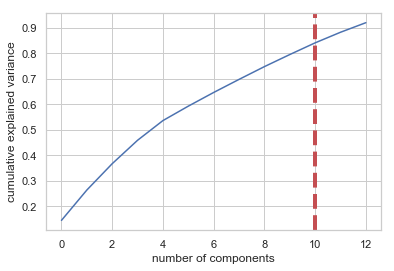

None

,Cumulative Variance Ratio,Explained Variance Ratio
0,0.145358,0.145358
1,0.264004,0.118646
2,0.367201,0.103197
3,0.458859,0.091658
4,0.535980,0.077121
5,0.592460,0.056480
6,0.645991,0.053531
7,0.697173,0.051181
8,0.747152,0.049979
9,0.794415,0.047263


In [33]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.transform(X_valid)
y_train_scaled = np.array(y_valid)

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
pca_test = PCA(n_components=13)
pca_test.fit(X_train_scaled)
sns.set(style='whitegrid')
plt.plot(np.cumsum(pca_test.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.axvline(linewidth=4, color='r', linestyle = '--', x=10, ymin=0, ymax=1)
display(plt.show())
evr = pca_test.explained_variance_ratio_
cvr = np.cumsum(pca_test.explained_variance_ratio_)
pca_df = pd.DataFrame()
pca_df['Cumulative Variance Ratio'] = cvr
pca_df['Explained Variance Ratio'] = evr
display(pca_df.head(10))

## Прогноз для реальных данных

In [34]:
print(features_to_predict)
print(test_x_ds.columns)

{'Square_small', 'BigHouseFloor', 'Floor', 'KitchenSquare_big', 'LifeSquare', 'Social_3', 'Shops_1', 'KitchenSquare_small', 'HouseYearBig', 'Rooms', 'HouseFloor', 'Social_1', 'fFloor', 'LifeSquare_nan', 'HouseYear', 'KitchenSquare', 'Square', 'Social_2', 'Ecology_1', 'Healthcare_1', 'Price'}
Index(['Id', 'DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare',
       'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Ecology_2',
       'Ecology_3', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1',
       'Helthcare_2', 'Shops_1', 'Shops_2'],
      dtype='object')


In [35]:
absent_cols = set(features_to_predict) - set(test_x_ds.columns)
absent_cols = absent_cols - {'Price'}
print(absent_cols)

{'Square_small', 'BigHouseFloor', 'HouseYearBig', 'KitchenSquare_big', 'fFloor', 'LifeSquare_nan', 'KitchenSquare_small'}


Колонки "absent_cols" это новые колонки которые будут расчитаны и добавлены в процессе выполнения скрипта

In [36]:
for nf in absent_cols:
    test_x_ds[nf] = 0

In [37]:
tranformers

[<function __main__.Kitchen_Transform(df)>,
 <function __main__.Square_Transform(df)>,
 <function __main__.Life_Transform(df)>,
 <function __main__.Rooms_Transform(df)>,
 <function __main__.Floor_Transform(df)>,
 <function __main__.Year_Transform(df)>,
 <function __main__.Healthcare_Transform(df)>,
 <function __main__.Binary_Transform(df)>,
 <function __main__.District_Transform(df)>,
 <function __main__.Rooms_Transform(df)>]

In [38]:
for f in tranformers:
    f(test_x_ds)

In [39]:
test_x_ds.columns

Index(['Id', 'DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare',
       'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Ecology_2',
       'Ecology_3', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1',
       'Helthcare_2', 'Shops_1', 'Shops_2', 'Square_small', 'BigHouseFloor',
       'HouseYearBig', 'KitchenSquare_big', 'fFloor', 'LifeSquare_nan',
       'KitchenSquare_small', 'Healthcare_1_nan'],
      dtype='object')

In [40]:
test_x_ds = test_x_ds[X_train.columns]

In [41]:
y_test_preds = rf_model.predict(test_x_ds)
preds = pd.DataFrame(y_test_preds)
test_y_ds['Price'] = y_test_preds
#print(test_y_ds['Price'].shape, y_test_preds.shape)
test_y_ds.to_csv('submit.csv', index=False)

In [42]:
y_test_preds

array([154395.14667103, 116203.56962762, 139937.29610601, ...,
       145819.67606324, 191889.03638454, 278609.88068523])